<a href="https://www.kaggle.com/code/nigamshitij/bear-classifier-resnet-data-augmentation?scriptVersionId=177009025" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/images-inference/grizzly_screen.jpg


In [3]:
# pip install nbdev

In [4]:
# pip install requests
!pip install -Uqq fastbook

In [5]:
from fastai import *
from fastai.vision import *
from fastai.vision.widgets import *
import requests
from fastcore.utils import L
from fastbook import *

In [6]:
bear_types = "grizzly", "polar", "black"
path = Path("bears")
path.resolve()

Path('/kaggle/working/bears')

In [7]:
if not path.exists():
    path.mkdir()

for bear in bear_types:
    destination = path/bear
    destination.mkdir(exist_ok = True)
    results = search_images_ddg(f"{bear} bear")
    download_images(destination, urls = results)

In [8]:
filenames = get_image_files(path)
filenames

(#1600) [Path('bears/polar/fb4b0bef-f828-46b8-a886-5b9934f62551.jpg'),Path('bears/polar/1b5f920e-6e07-48b7-b26f-9914ec67e196.jpg'),Path('bears/polar/e4269d1b-61ca-40af-84c5-0202ea524e43.jpg'),Path('bears/polar/bfb965ac-fc65-4b54-ae81-c6c2374bd360.jpg'),Path('bears/polar/5186f0f4-871f-40a7-b5c5-e29194d294ca.jpg'),Path('bears/polar/d4a147f2-b444-4774-89bc-7446ff9a6407.jpg'),Path('bears/polar/25804066-1cc4-4c45-9f7a-e5e79bf1c818.JPG'),Path('bears/polar/59944363-c962-440b-a30e-3d617d2243be.jpg'),Path('bears/polar/e311be62-f1c2-43fc-8266-72af08358d59.jpg'),Path('bears/polar/26dd72b4-095c-4b3d-8c52-acd218bb24be.jpg')...]

In [9]:
# doc(get_image_files)
failed = verify_images(filenames)
failed

(#18) [Path('bears/polar/26dd72b4-095c-4b3d-8c52-acd218bb24be.jpg'),Path('bears/polar/22172b84-c796-4b3c-80c8-94f6687eb3bf.jpg'),Path('bears/polar/08a0546c-069f-4f6f-bf86-86727459683a.jpg'),Path('bears/polar/d917f307-842d-4ea9-a205-ed62f2ecb50f.jpg'),Path('bears/polar/984ae042-4953-49af-95c7-bc611901a742.jpg'),Path('bears/polar/c020d028-4adf-4ec1-a77e-99aad698067e.jpeg'),Path('bears/polar/018aa1a8-adb1-4a60-8c02-15bdacb630df.jpg'),Path('bears/polar/425ace6b-0eb1-4c02-b94f-9d5d35ea91f9.jpg'),Path('bears/black/5315b939-1d50-4145-a4d4-9f2e8b7dd8c5.jpg'),Path('bears/black/013f7169-6ff3-43f1-ad5d-aa9fb5951c67.jpg')...]

In [10]:
failed.map(Path.unlink)

(#18) [None,None,None,None,None,None,None,None,None,None...]

In [11]:
failed = verify_images(filenames)
failed

(#18) [Path('bears/polar/26dd72b4-095c-4b3d-8c52-acd218bb24be.jpg'),Path('bears/polar/22172b84-c796-4b3c-80c8-94f6687eb3bf.jpg'),Path('bears/polar/08a0546c-069f-4f6f-bf86-86727459683a.jpg'),Path('bears/polar/d917f307-842d-4ea9-a205-ed62f2ecb50f.jpg'),Path('bears/polar/984ae042-4953-49af-95c7-bc611901a742.jpg'),Path('bears/polar/c020d028-4adf-4ec1-a77e-99aad698067e.jpeg'),Path('bears/polar/018aa1a8-adb1-4a60-8c02-15bdacb630df.jpg'),Path('bears/polar/425ace6b-0eb1-4c02-b94f-9d5d35ea91f9.jpg'),Path('bears/black/5315b939-1d50-4145-a4d4-9f2e8b7dd8c5.jpg'),Path('bears/black/013f7169-6ff3-43f1-ad5d-aa9fb5951c67.jpg')...]

In [12]:
bear_datablock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [13]:
# doc(DataBlock)
# doc(ImageBlock)
# doc(TransformBlock)
# doc(CategoryBlock)
# CategoryBlock?

In [14]:
dataloaders = bear_datablock.dataloaders(path)

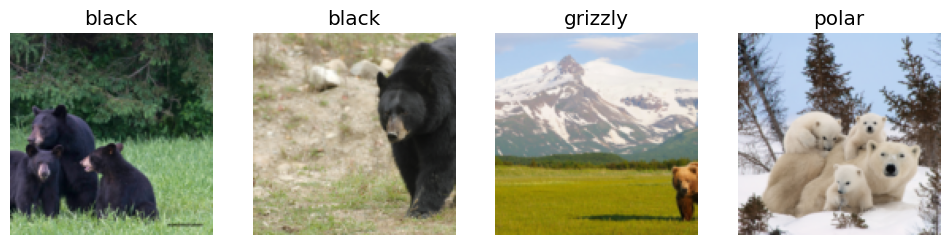

In [15]:
dataloaders.show_batch(max_n = 4, nrows = 1)

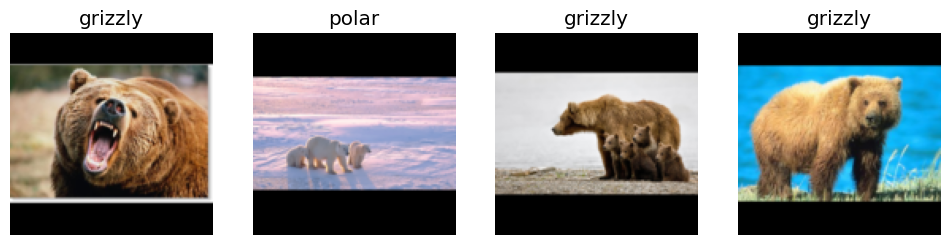

In [16]:
bear_datablock = bear_datablock.new(
    item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros')
)

dataloaders = bear_datablock.dataloaders(path)
dataloaders.valid.show_batch(max_n = 4, nrows = 1)

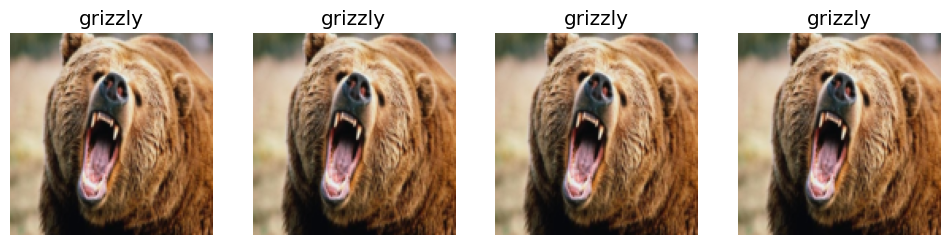

In [17]:
bear_datablock = bear_datablock.new(
    item_tfms = RandomResizedCrop(128, min_scale = 0.3)
)

dataloaders = bear_datablock.dataloaders(path)
dataloaders.valid.show_batch(max_n = 4, nrows = 1, unique = True)

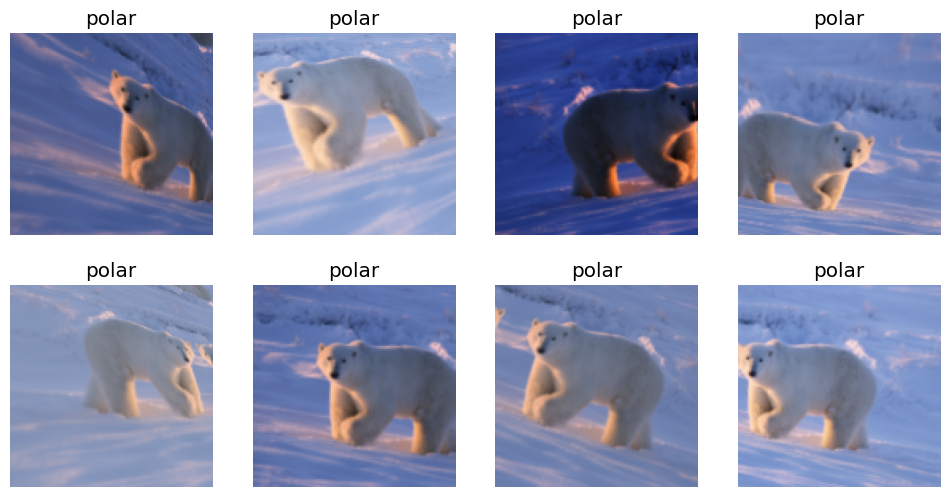

In [18]:
bear_datablock = bear_datablock.new(
    item_tfms = Resize(128),
    batch_tfms = aug_transforms(mult=2)
)
dataloaders = bear_datablock.dataloaders(path)
dataloaders.train.show_batch(
    max_n = 8,
    nrows = 2,
    unique = True
)

In [19]:
bear_datablock = bear_datablock.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)
dataloaders = bear_datablock.dataloaders(path)

In [20]:
learner = vision_learner(
    dataloaders,
    resnet18,
    metrics = error_rate
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s] 


In [21]:
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.712979,0.401178,0.082278,00:34


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.225895,0.280810,0.082278,00:34
1,0.171244,0.261397,0.063291,00:35
2,0.150131,0.258898,0.050633,00:35
3,0.117330,0.247750,0.047468,00:35


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

In [22]:
# Interpretation??
interpretation = ClassificationInterpretation.from_learner(learner)

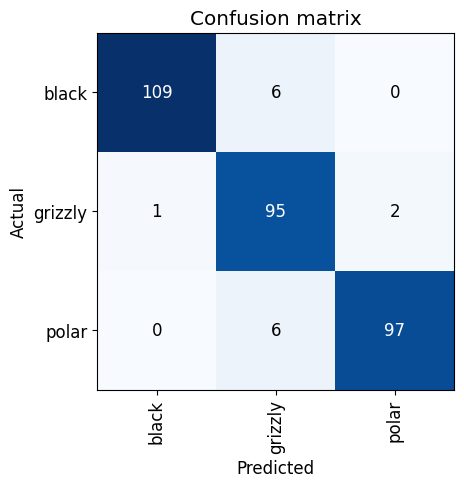

In [23]:
interpretation.plot_confusion_matrix()

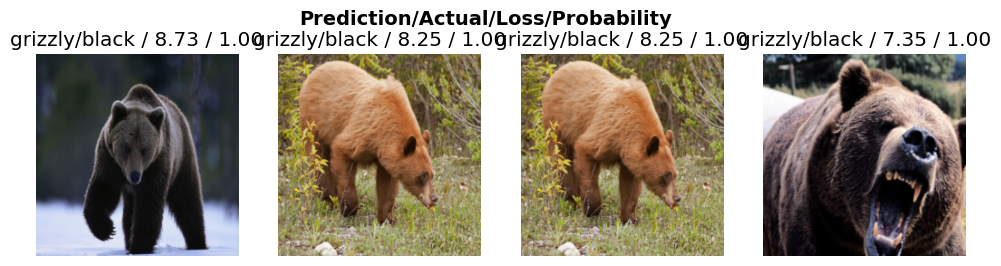

In [24]:
interpretation.plot_top_losses(4, nrows = 1)

In [25]:
cleaner = ImageClassifierCleaner(learner)
cleaner

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [26]:
# for idx in cleaner.delete(): 
#     cleaner.fns[idx].unlink()
    
# for index,category in cleaner.change(): 
#     shutil.move(str(cleaner.fns[index]), path/category)

In [27]:
# bear_datablock = bear_datablock.new(
#     item_tfms = RandomResizedCrop(224, min_scale = 0.5),
#     batch_tfms = aug_transforms()
# )
# dataloaders = bear_datablock.dataloaders(path)

# learner = vision_learner(
#     dataloaders,
#     resnet18,
#     metrics = error_rate
# )

# learner.fine_tune(4)

In [28]:
# interpretation = ClassificationInterpretation.from_learner(learner)
# interpretation.plot_confusion_matrix()

In [29]:
# interpretation.plot_top_losses(7, nrows = 2)

In [30]:
# cleaner = ImageClassifierCleaner(learner)
# cleaner

In [31]:
learner.export()

In [32]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [33]:
learner_inference = load_learner(path/'export.pkl')

In [34]:
inf_path = '/kaggle/input/images-inference/grizzly_screen.jpg'
learner_inference.predict(inf_path)

('grizzly', tensor(1), tensor([1.3537e-05, 9.9998e-01, 1.1255e-05]))

In [35]:
learner_inference.dls.vocab

['black', 'grizzly', 'polar']

In [36]:
button_upload = widgets.FileUpload()
button_upload

FileUpload(value={}, description='Upload')

In [37]:
button_upload = SimpleNamespace(data = [inf_path])
image = PILImage.create(button_upload.data[-1])

In [38]:
output_placeholder = widgets.Output()
output_placeholder.clear_output()
with output_placeholder:
    display(image.to_thumb(128,128))
output_placeholder

Output()

In [39]:
prediction, prediction_index , probability = learner_inference.predict(image)
label_prediction = widgets.Label()
label_prediction.value = f'Prediction: {prediction}; Probability: {probability[prediction_index]:.04f}'
label_prediction
# lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'


Label(value='Prediction: grizzly; Probability: 1.0000')

In [40]:
button_run = widgets.Button(description = 'Classify')
button_run

Button(description='Classify', style=ButtonStyle())

In [41]:
def on_click_classify(change):
    image = PILImage.create(button_upload.data[-1])
    output_placeholder.clear_output()
    with output_placeholder:
        display(image.to_thumb(128, 128))
    prediction, prediction_index, probabilities = learner_inference.predict(image)
    label_prediction.value =  f'Prediction: {prediction}; Probability: {probabilities[prediction_index]:.04f}'

button_run.on_click(on_click_classify)

In [42]:
button_upload = widgets.FileUpload()
VBox([
    widgets.Label('Select your bear!'),
    button_upload,
    button_run,
    output_placeholder,
    label_prediction]
    )